# Outlier detection with Isolation Forests
## (and a comparison with other methods)
adapted from : https://scikit-learn.org/0.18/auto_examples/covariance/plot_outlier_detection.html

In this notebook, we will look at synthetic data and compare the performance of Isolation Forests with two other outlier detection methods.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# compare three different outlier detection algorithms
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

## Methods to compare:
### One-Class SVM
* Simple method to determine outlier status or "novelty" based on density of distribution
* Requires fine-tuning of hyperparameters to handle outliers and prevent overfitting

### Robust Covariance
* Fits a robust covariance estimate to the data 
* Assumes the data is Gaussian and learning an ellipse

### Isolation Forest
* No assumption on distribution
* Performs well on multi-modal datasets

In [18]:
# Example settings
n_samples = 200                 # total number of points
outliers_fraction = 0.20        # fration of outliers
clusters_separation = [0, 1, 2] # distance between cluster centroids

# define outlier detection tools to be compared
classifiers = {
    "One-Class SVM": OneClassSVM(nu     = 0.95 * outliers_fraction + 0.05, 
                                 kernel = "rbf", 
                                 gamma  = 0.1),
    
    "Robust covariance": EllipticEnvelope(contamination = outliers_fraction),
    
    "Isolation Forest": IsolationForest(max_samples   = n_samples, 
                                        contamination = outliers_fraction)}

## Create synthetic datasets and plot performance 
* Use two clusters of inliers, separated by varying amounts
* Score the algorithms on their ability to learn the correct boundary

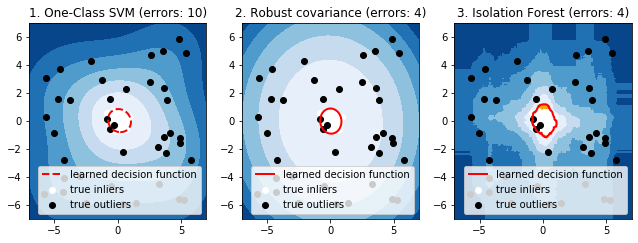

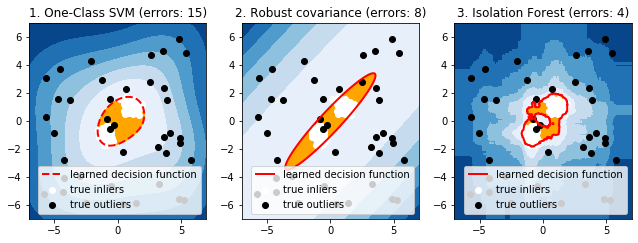

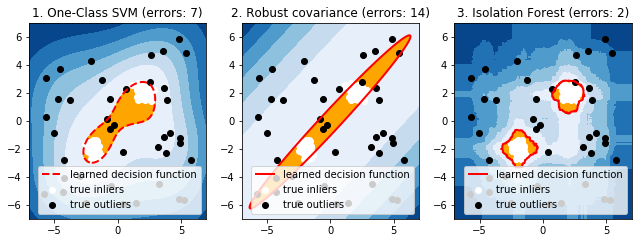

In [24]:
# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(1)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    
    # Add outliers
    X = np.r_[X1, X2]
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # plot performance
    plt.figure(figsize=(10.8, 3.6))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
       
        # fit the data and tag outliers using known outlier_fraction
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        threshold   = stats.scoreatpercentile(scores_pred,
                                              100 * outliers_fraction)
        # predict and measure error
        y_pred   = clf.predict(X)
        n_errors = (y_pred != ground_truth).sum()
        
        # new subplot
        subplot = plt.subplot(1, 3, i + 1)
        
        # evaluate every point on the grid to get contour
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        
        # plot decision boundary and color insisde
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
       
        # plot classified points
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        
        # configure plots
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            loc='lower right')
        subplot.set_title("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
plt.show()